## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [1]:
pip install swifter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 21.9 MB/s 
     |████████████████████████████████| 281 kB 62.1 MB/s 
     |████████████████████████████████| 1.6 MB 53.5 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=493345887fbd134eed67e6666f6760a25f92fc5ff81bed17b6bbffcd7b6382d0
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import swifter
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
#f = '/content/drive/MyDrive/complaints.json' # Write the path to your data file and load it 
with open("/content/drive/MyDrive/complaints.json","r") as f:
# returns JSON object as  
# a dictionary 
  data=json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state _source.consumer_disputed  \
0  2019-04-13T12:00:00-05:00            CA                       N/A   
1  2019-05-01T12:00:00-05:00            GA                       N/A   
2  2019-04-02T12:00:00-05:00            TX                       N/A   
3  2017-09-13T12:00:00-05:00            MI                       N/A   
4  2019-04-05T12:00:00-05:00            NY                       N/A   

               _source.product _source.company_response       _source.company  \
0              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
1              Debt collection  Closed with explanation  JPMORGAN CHASE & CO.   
2  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.   
3                     Mortgage  Closed with explanation  JPMORGAN CHASE & CO.   
4  Credit card or prepaid card  Closed with explanation  JPMORGAN CHASE & CO.   

  _source.submitted_via _source.date_sent_to_company  \
0                   Web    2019-04-13T12:00:00-05:00   
1                   Web    2019-05-01T12:00:00-05:00   
2                   Web    2019-04-02T12:00:00-05:00   
3                   Web    2017-09-14T12:00:00-05:00   
4              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely  \
0            Yes   
1            Yes   
2            Yes   
3            Yes   
4            Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                              _source.complaint_what_happened  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to vali

In [5]:
df.shape

(78313, 22)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
df.columns=['index', 'type', 'id', 'score', 'source_tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

In [10]:
df['len_text']=df['complaint_what_happened'].apply(lambda x:len(x))

In [11]:
df.head()

index       type       id  score    source_tags zip_code  \
0  complaint-public-v2  complaint  3211475    0.0           None    90301   
1  complaint-public-v2  complaint  3229299    0.0  Servicemember    319XX   
2  complaint-public-v2  complaint  3199379    0.0           None    77069   
3  complaint-public-v2  complaint  2673060    0.0           None    48066   
4  complaint-public-v2  complaint  3203545    0.0           None    10473   

  complaint_id                               issue              date_received  \
0      3211475   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00   
1      3229299     Written notification about debt  2019-05-01T12:00:00-05:00   
2      3199379  Other features, terms, or problems  2019-04-02T12:00:00-05:00   
3      2673060      Trouble during payment process  2017-09-13T12:00:00-05:00   
4      3203545                    Fees or interest  2019-04-05T12:00:00-05:00   

  state consumer_disputed                      product  \
0    CA               N/A              Debt collection   
1    GA               N/A              Debt collection   
2    TX               N/A  Credit card or prepaid card   
3    MI               N/A                     Mortgage   
4    NY               N/A  Credit card or prepaid card   

          company_response               company submitted_via  \
0  Closed with explanation  JPMORGAN CHASE & CO.           Web   
1  Closed with explanation  JPMORGAN CHASE & CO.           Web   
2  Closed with explanation  JPMORGAN CHASE & CO.           Web   
3  Closed with explanation  JPMORGAN CHASE & CO.           Web   
4  Closed with explanation  JPMORGAN CHASE & CO.      Referral   

        date_sent_to_company company_public_response  \
0  2019-04-13T12:00:00-05:00                    None   
1  2019-05-01T12:00:00-05:00                    None   
2  2019-04-02T12:00:00-05:00                    None   
3  2017-09-14T12:00:00-05:00                    None   
4  2019-04-05T12:00:00-05:00                    None   

                                  sub_product timely  \
0                            Credit card debt    Yes   
1                            Credit card debt    Yes   
2  General-purpose credit card or charge card    Yes   
3                  Conventional home mortgage    Yes   
4  General-purpose credit card or charge card    Yes   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      complaint_what_happened  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   
2                                                                                                                                         I upgraded my XXXX

In [12]:
df['len_text'].astype('int')

0            0
1          486
2          355
3            0
4            0
5            0
6            0
7            0
8            0
9            0
10         224
11        1502
12           0
13           0
14         477
15          29
16           0
17        2277
18           0
19           0
20        1396
21        3541
22           0
23         129
24          51
25           0
26         753
27         413
28           0
29           0
30         566
31           0
32        1972
33           0
34           0
35         538
36           0
37           0
38           0
39           0
40         165
41           0
42         189
43         934
44           0
45        1920
46           0
47           0
48        1229
49           0
50         350
51           0
52         843
53           0
54           0
55           0
56           0
57         190
58        1274
59        1897
60           0
61           0
62           0
63         283
64        1271
65        1089
66        

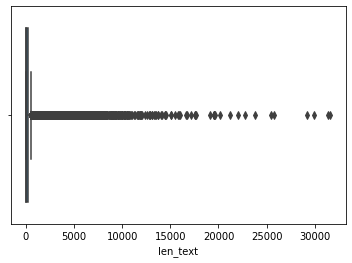

In [13]:
sns.boxplot(df['len_text'])

In [14]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("",np.NaN,inplace=True)

In [15]:
df['complaint_what_happened'].isnull().sum()

57241

In [16]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [17]:
df.shape

(21072, 23)

In [18]:
df['complaint_what_happened'][0:5]

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
def basic_clean(df):
  x=df['complaint_what_happened']
  x=x.lower()
  symbols = "!\"#$%&()*+-.',/:;<=>?@[\]^_`{|}~\n"
  for i in symbols:
        x = np.char.replace(x, i, '')
  x=re.sub(r'\d+','',str(x))
  return x

df['processed_complaint']=df.apply(basic_clean,axis=1)

In [20]:
df['processed_complaint']=df['processed_complaint'].apply(lambda x:' '.join([ re.sub(r'x+', '', item)  for item in x.split() ]))

In [21]:
#Write your function to Lemmatize the texts

spacy_nlp_en = spacy.load('en_core_web_sm',disable=['parser','ner'])
df['lemmatized_complaint']=df['processed_complaint'].swifter.apply(lambda x:' '.join([word.lemma_ for word in spacy_nlp_en(x)]))

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [22]:
df['lemmatized_complaint'][0:1]

1    good morning my name be    and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account      thank in advance for your help
Name: lemmatized_complaint, dtype: object

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 


In [23]:
df_clean=df[['complaint_what_happened','processed_complaint','lemmatized_complaint']]

In [24]:
#Write your function to extract the POS tags 
def pos_tag(df_clean):
  # write your code here
  s=''
  x=spacy_nlp_en(df_clean['lemmatized_complaint'])
  for i in x:
    if i.tag_=="NN":
      s=s+" "+str(i)
  return s



df_clean["complaint_POS_removed"] = df_clean.swifter.apply(pos_tag,axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [25]:
y=spacy_nlp_en('chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not etend credit without verifying the identity of the applicant')
for i in y:
  print(i,i.pos_)

chase NOUN
card NOUN
was AUX
reported VERB
on ADP
however ADV
fraudulent ADJ
application NOUN
have AUX
been AUX
submitted VERB
my PRON
identity NOUN
without ADP
my PRON
consent NOUN
to PART
fraudulently ADV
obtain VERB
services NOUN
do AUX
not PART
etend VERB
credit NOUN
without ADP
verifying VERB
the DET
identity NOUN
of ADP
the DET
applicant NOUN


In [ ]:
#df_clean[0:23]

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()


complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['len']=df_clean['complaint_POS_removed'].apply(lambda x:len(x))

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_complaint = ' '.join(df_clean['complaint_POS_removed'])
from wordcloud import WordCloud, STOPWORDS

stopwords = STOPWORDS
stopwords.add('will')

wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=40).generate(all_complaint)

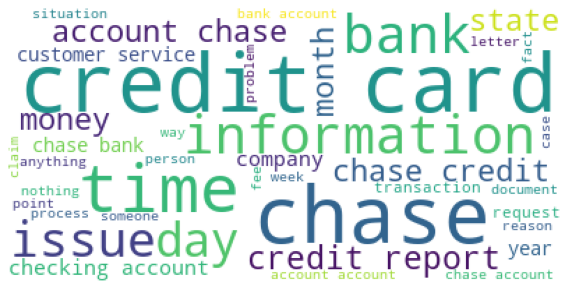

In [29]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
#df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [30]:
df_clean['lemmatized_complaint'].iloc[0]

'good morning my name be    and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account      thank in advance for your help'

In [31]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [34]:
df_clean['1_gram']=np.nan

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [35]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from nltk.tokenize import word_tokenize
def generate_N_grams(text,ngram):
  words=[word for word in word_tokenize(text) if word.lower() not in sw_spacy ]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans
for i in range(len(df_clean)):
  j=df_clean['lemmatized_complaint'].iloc[i]
  df_clean['1_gram'].iloc[i]=generate_N_grams(j,1)

In [36]:
df_clean['1_gram'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [good, morning, appreciate, help, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, month, attempt, collect, debt, right, know, information, consumer, chase, account, thank, advance, help]
2                                                                                                                                                                                   

In [37]:
#Print the top 10 words in the unigram frequency
from collections import Counter
l=[]
for i in range(len(df_clean)):
  for j in df_clean['1_gram'].iloc[i]:
    l.append(j)
l = Counter(l)
l.most_common(10)

[('chase', 80409),
 ('account', 48601),
 ('credit', 34132),
 ('card', 30508),
 ('bank', 28411),
 ('payment', 21172),
 ('tell', 19677),
 ('charge', 18220),
 ('receive', 17721),
 ('pay', 16659)]

In [38]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [39]:
df_clean['bi_gram']=np.nan

In [40]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
from nltk.tokenize import word_tokenize
def generate_N_grams(text,ngram):
  words=[word for word in word_tokenize(text) if word.lower() not in sw_spacy]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans
for i in range(len(df_clean)):
  j=df_clean['lemmatized_complaint'].iloc[i]
  df_clean['bi_gram'].iloc[i]=generate_N_grams(j,2)

In [41]:
#Print the top 10 words in the bigram frequency
from collections import Counter
bi_gram=[]
for i in range(len(df_clean)):
  for j in df_clean['bi_gram'].iloc[i]:
    bi_gram.append(j)
bi_gram = Counter(bi_gram)
bi_gram.most_common(10)

[('chase bank', 12821),
 ('credit card', 12807),
 ('credit report', 3963),
 ('checking account', 3283),
 ('customer service', 3064),
 ('close account', 2953),
 ('jp morgan', 2876),
 ('account chase', 2845),
 ('chase credit', 2685),
 ('morgan chase', 2472)]

In [42]:
df_clean['tri_gram']=np.nan

In [43]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def generate_N_grams(text,ngram):
  words=[word for word in word_tokenize(text) if word.lower() not in sw_spacy]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans
for i in range(len(df_clean)):
  j=df_clean['lemmatized_complaint'].iloc[i]
  df_clean['tri_gram'].iloc[i]=generate_N_grams(j,3)

In [44]:
#Print the top 10 words in the trigram frequency
tri_gram=[]
for i in range(len(df_clean)):
  for j in df_clean['tri_gram'].iloc[i]:
    tri_gram.append(j)
tri_gram = Counter(tri_gram)
tri_gram.most_common(10)

[('jp morgan chase', 2359),
 ('chase credit card', 2256),
 ('credit card account', 985),
 ('credit card company', 967),
 ('credit card chase', 804),
 ('account chase bank', 719),
 ('morgan chase bank', 677),
 ('receive letter chase', 582),
 ('chase customer service', 549),
 ('inquiry credit report', 443)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [45]:
#All masked texts has been removed
df_clean.head()

complaint_what_happened  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.   
10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [46]:
df_clean['complaint_POS_removed']=df_clean['complaint_POS_removed'].apply(lambda x: ' '.join([item.lower() for item in x.split() if item.lower() not in sw_spacy]))

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [47]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer, TfidfTransformer
tfidfconverter = TfidfVectorizer(max_df = 0.95,min_df = 2)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [48]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
x = tfidfconverter.fit_transform(list(df_clean['complaint_POS_removed'])).toarray()
x_tfidf = pd.DataFrame(x,columns=tfidfconverter.get_feature_names_out())

In [49]:
x_tfidf.head()

aa  aarp   ab  aba  abandonment  abatement  abbreviation  abet  abide  \
0  0.0   0.0  0.0  0.0          0.0        0.0           0.0   0.0    0.0   
1  0.0   0.0  0.0  0.0          0.0        0.0           0.0   0.0    0.0   
2  0.0   0.0  0.0  0.0          0.0        0.0           0.0   0.0    0.0   
3  0.0   0.0  0.0  0.0          0.0        0.0           0.0   0.0    0.0   
4  0.0   0.0  0.0  0.0          0.0        0.0           0.0   0.0    0.0   

   ability  abovereference  absence  absent  absolve  absurdity  abundance  \
0      0.0             0.0      0.0     0.0      0.0        0.0        0.0   
1      0.0             0.0      0.0     0.0      0.0        0.0        0.0   
2      0.0             0.0      0.0     0.0      0.0        0.0        0.0   
3      0.0             0.0      0.0     0.0      0.0        0.0        0.0   
4      0.0             0.0      0.0     0.0      0.0        0.0        0.0   

   abuse  abuser  abusive   ac  acc  acccount  acceleration  accent  accept  \
0    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
1    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
2    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
3    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
4    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   

   acceptance  access  accessibility  accessory  accident  accommodation  \
0         0.0     0.0            0.0        0.0       0.0            0.0   
1         0.0     0.0            0.0        0.0       0.0            0.0   
2         0.0     0.0            0.0        0.0       0.0            0.0   
3         0.0     0.0            0.0        0.0       0.0            0.0   
4         0.0     0.0            0.0        0.0       0.0            0.0   

   accomodation  accompany  accomplice  accont  accord  accordance  accou  \
0           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
1           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
2           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
3           0.0        0.0         0.0     0.0     0.0         0.0    0.0   
4           0.0        0.0         0.0     0.0     0.0         0.0    0.0   

   accouint  accoun  accound   account  accountability  accountalso  \
0       0.0     0.0      0.0  0.089552             0.0          0.0   
1       0.0     0.0      0.0  0.067641             0.0          0.0   
2       0.0     0.0      0.0  0.000000             0.0          0.0   
3       0.0     0.0      0.0  0.115786             0.0          0.0   
4       0.0     0.0      0.0  0.129815             0.0          0.0   

   accountand  accountant  accountchase  accountholder  accounti  accounting  \
0         0.0         0.0           0.0            0.0       0.0         0.0   
1         0.0         0.0           0.0            0.0       0.0         0.0   
2         0.0         0.0           0.0            0.0       0.0         0.0   
3         0.0         0.0           0.0            0.0       0.0         0.0   
4         0.0         0.0           0.0            0.0       0.0         0.0   

   accountit  accountlevel  accountone  accountplease  accountshe  \
0        0.0           0.0         0.0            0.0         0.0   
1        0.0           0.0         0.0            0.0         0.0   
2        0.0           0.0         0.0            0.0         0.0   
3        0.0           0.0         0.0            0.0         0.0   
4        0.0           0.0         0.0            0.0         0.0   

   accountsince  accountwe  accout  accredit  accrue  acct  accumulate  \
0           0.0        0.0     0.0       0.0     0.0   0.0         0.0   
1           0.0        0.0     0.0       0.0     0.0   0.0         0.0   
2           0.0        0.0     0.0       0.0     0.0   0.0         0.0   
3           0.0        0.0     0.0       0.0     0.0   0.0

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [50]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [51]:
#Load your nmf_model with the n_components i.e 5
num_topics =5 #write the value you want to test out

#keep the 
 
nmf_model =  NMF(random_state =40,n_components=num_topics)
#write your code here

In [52]:
W=nmf_model.fit_transform(x)


In [53]:
H = nmf_model.components_       # Topic-term matrix

In [54]:
H[0]

array([0.00000000e+00, 0.00000000e+00, 1.30747449e-04, ...,
       3.27108799e-05, 0.00000000e+00, 3.38745341e-04])

In [55]:
#Print the Top15 words for each of the topics
words = np.array(tfidfconverter.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

Word 1    Word 2    Word 3   Word 4        Word 5     Word 6  \
Topic 1  account     check      bank    money         chase       fund   
Topic 2   credit      card    report  inquiry         chase    account   
Topic 3     loan  mortgage     chase     home  modification   property   
Topic 4   charge      card     chase  dispute   transaction        fee   
Topic 5  payment   balance  interest    month           fee  statement   

           Word 7    Word 8    Word 9 Word 10      Word 11      Word 12  \
Topic 1   deposit  checking    branch     day       number     business   
Topic 2     score   company      debt   limit  information  application   
Topic 3      year    letter  document    time  foreclosure         rate   
Topic 4  merchant  purchase     claim   fraud      service         time   
Topic 5       day      time      bill   chase         auto         date   

             Word 13    Word 14    Word 15  
Topic 1  transaction   transfer   customer  
Topic 2       letter       year  reporting  
Topic 3        house       sale    request  
Topic 4        email  statement     refund  
Topic 5          pay     credit       year

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4


In [56]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1)
#write your code to assign topics to each rows.

In [ ]:
#df_clean.drop(['1_gram','bi_gram','tri_gram'],axis=1,inplace=True)

In [57]:
df_clean.head(1)

complaint_what_happened  \
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   

                                                                                                                                                                                                                                                                                                                                                                                                                                             processed_complaint  \
1  good morning my name is   and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account     thanks in advance for your help   

                                                                                                                                                                                                                                                                                                                                                                                                                             lemmatized_complaint  \
1  good morning my name be    and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account      thank in advance for your help   

                                                                                                      complaint_POS_removed  \
1  morning stop debt verification statement bank debt mail month debt right information consumer chase account advance help   

   len  \
1  126   

                                                                                                                                                                                                                                                                                                      1_gram  \
1  [good, morning, appreciate, help, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, month, attempt, collect, debt, right, know, information, consumer, chase, account, thank, advance, help]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              bi_gram  \
1  [good morning, morning appreciate, appreciate help, help stop, stop chase, chase bank, bank cardmember, cardmember service, service write, write chase, chase ask, ask debt, debt verification, verification send, send statement, statement acceptable, accep

In [58]:
#Print the first 5 Complaint for each of the Topics
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

complaint_what_happened  \
27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [59]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               4:"Others",
               3:"Theft/Dispute Reporting",
               2:"Mortgage/Loan"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [60]:
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

complaint_what_happened  \
27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [61]:
df_clean.head(1)

complaint_what_happened  \
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   

                                                                                                                                                                                                                                                                                                                                                                                                                                             processed_complaint  \
1  good morning my name is   and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account     thanks in advance for your help   

                                                                                                                                                                                                                                                                                                                                                                                                                             lemmatized_complaint  \
1  good morning my name be    and I appreciate it if you could help I put a stop to chase bank cardmember service in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt I have a right to know this information as a consumer chase account      thank in advance for your help   

                                                                                                      complaint_POS_removed  \
1  morning stop debt verification statement bank debt mail month debt right information consumer chase account advance help   

   len  \
1  126   

                                                                                                                                                                                                                                                                                                      1_gram  \
1  [good, morning, appreciate, help, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, month, attempt, collect, debt, right, know, information, consumer, chase, account, thank, advance, help]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              bi_gram  \
1  [good morning, morning appreciate, appreciate help, help stop, stop chase, chase bank, bank cardmember, cardmember service, service write, write chase, chase ask, ask debt, debt verification, verification send, send statement, statement acceptable, accep

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [62]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":0,
               "Credit card or prepaid card":1, 
               "Others":4,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":2  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
#df_clean

In [63]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]


In [64]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(df_clean['lemmatized_complaint'], df_clean.Topic, test_size=0.25, random_state=42)

#Write your code to get the Vector count

count_vector=CountVectorizer()
#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(X_train)
X_test=count_vector.transform(X_test)

tfidf_transform= TfidfTransformer()
X_train = tfidf_transform.fit_transform(X_train_count)
X_test = tfidf_transform.transform(X_test)



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [66]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(multi_class='multinomial') 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [67]:
print(accuracy_score(y_test, y_pred_lr))

0.9244495064540622


In [68]:
lr_f1 = f1_score(y_test, y_pred_lr, average="weighted")
lr_f1

0.9245381176298121

In [69]:
param = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lr_grid = GridSearchCV(estimator=lr, 
                       param_grid=param,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1_weighted', verbose=1)

In [70]:
print(lr_grid.best_params_)

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [71]:
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [72]:
print(accuracy_score(y_test, y_pred_lr_tuned))


0.9403948367501899


In [73]:
lr_tuned_f1 = f1_score(y_test, y_pred_lr_tuned, average="weighted")
lr_tuned_f1

0.9404494006045554

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred_dt))

0.8116932422171602


In [ ]:
param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

dt_grid = GridSearchCV(estimator=dt, 
                       param_grid=param,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
dt_grid.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 25]},
             scoring='f1_weighted', verbose=1)

In [ ]:
print(dt_grid.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 25}


In [ ]:
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=20, 
                                      min_samples_leaf=25, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred_dt_tuned))

0.8160592255125285


In [ ]:
dt_tuned_f1 = f1_score(y_test, y_pred_dt_tuned, average="weighted")
dt_tuned_f1

0.8161306528925296

In [ ]:
##Ranndom forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_jobs=-1)

In [ ]:
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [ ]:
y_test_pred_rf= classifier_rf.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_test_pred_rf))

0.8168185269552012


In [ ]:
params = {
    'min_samples_split': [4,6,9,15],
    'min_samples_leaf': [3,5,7],
    'n_estimators': [ 80,130,160]
}
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "f1_weighted")
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [4, 6, 9, 15],
                         'n_estimators': [80, 130, 160]},
             scoring='f1_weighted', verbose=1)

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(min_samples_leaf=3, min_samples_split=4,
                       n_estimators=130, n_jobs=-1)

In [ ]:
classifier_rf = RandomForestClassifier(min_samples_split=4, min_samples_leaf=3, n_estimators=130,
                       n_jobs=-1, random_state=42)
classifier_rf.fit(X_train, y_train)
y_test_rf_tuned_pred = classifier_rf.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_test_rf_tuned_pred))

0.8041002277904328


In [ ]:
df_tuned_f1 = f1_score(y_test, y_test_rf_tuned_pred, average="weighted")
df_tuned_f1

0.7953148216578921

In [ ]:
df_clean['lemmatized_complaint'].shape

(21072,)

In [ ]:
df_clean.Topic.shape

(21072,)

In [ ]:
#naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(df_clean['lemmatized_complaint'], df_clean.Topic, random_state=1,test_size=0.25)
vect = CountVectorizer()

vect.fit(X_train_cv)

CountVectorizer()

In [ ]:
len(vect.vocabulary_.keys())

24456

In [ ]:
X_train_transformed = vect.transform(X_train_cv)
X_test_transformed = vect.transform(X_test_cv)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train_cv)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [ ]:
metrics.accuracy_score(y_test_cv, y_pred_class)

0.8067577828397874

In [ ]:
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_mnb = GridSearchCV(estimator=mnb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_mnb.fit(X_train_transformed,y_train_cv)
print(grid_mnb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 1, 'fit_prior': True}


In [ ]:

mnb_tuned = MultinomialNB(alpha=1,fit_prior=True)
mnb_tuned.fit(X_train_transformed,y_train_cv)
y_pred_nb_tuned = mnb_tuned.predict(X_test_transformed)

In [ ]:
metrics.accuracy_score(y_test_cv, y_pred_nb_tuned)

0.8067577828397874

In [ ]:
df_tuned_f1 = f1_score(y_test_cv, y_pred_nb_tuned, average="weighted")
df_tuned_f1

0.8068434058500235

In [ ]:
Topic_names1 = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               4:"Others",
               3:"Theft/Dispute Reporting",
               2:"Mortgage/Loan"  }

In [81]:
df_clean['complaint_POS_removed'].iloc[99]

'link chase freedom credit card referrer bonus referee bonus month referrer confirm point month statement point account chase account supervisor center state record promotion bank type record year month screenshot bonus month chase earn bonus customer earn bonus'

In [ ]:
#LDA

In [ ]:
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim 




In [ ]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['lemmatized_complaint'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['on', 'while', 'try', 'to', 'book', 'ticket', 'come', 'across', 'an', 'offer', 'for', 'to', 'be', 'apply', 'towards', 'the', 'ticket', 'if', 'apply', 'for', 'reward', 'card', 'put', 'in', 'my', 'information', 'for', 'the', 'offer', 'and', 'within', 'less', 'than', 'minute', 'be', 'notify', 'via', 'the', 'screen', 'that', 'decision', 'could', 'not', 'be', 'make', 'immediately', 'contact', 'and', 'be', 'refer', 'to', 'chase', 'bank', 'then', 'immediately', 'contact', 'chase', 'bank', 'within', 'no', 'more', 'than', 'minute', 'of', 'get', 'the', 'notification', 'on', 'the', 'screen', 'and', 'be', 'tell', 'by', 'the', 'chase', 'representative', 'speak', 'with', 'that', 'my', 'application', 'be', 'deny', 'but', 'she', 'could', 'not', 'state', 'why', 'ask', 'for', 'more', 'information', 'about', 'the', 'offer', 'and', 'she', 'eplaine', 'that', 'even', 'if', 'have', 'be', 'approve', 'the', 'credit', 'offer', 'only', 'get', 'apply', 'after', 'the', 'first', 'account', 'statement', 'and', 'cou

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = spacy_nlp_en(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# call functions

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en' model, use only tagger since we don't need parsing or NER 
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['try', 'book', 'ticket', 'come', 'offer', 'apply', 'ticket', 'apply', 'reward', 'card', 'put', 'information', 'offer', 'less', 'minute', 'notify', 'screen', 'decision', 'make', 'immediately', 'contact', 'refer', 'immediately', 'contact', 'chase', 'minute', 'get', 'notification', 'screen', 'tell', 'chase', 'representative', 'speak', 'application', 'deny', 'state', 'ask', 'information', 'offer', 'eplaine', 'even', 'approve', 'credit', 'offer', 'get', 'apply', 'first', 'account', 'statement', 'use', 'purchase', 'ticket', 'eplicitly', 'tell', 'glad', 'get', 'deny', 'absolutely', 'long', 'interested', 'account', 'ask', 'application', 'withdraw', 'representative', 'oblige', 'happen', 'later', 'put', 'application', 'eplicit', 'request', 'proceed', 'application', 'contrary', 'chase', 'representative', 'chase', 'fact', 'go', 'ahead', 'open', 'credit', 'account', 'name', 'report', 'credit', 'report', 'chase', 'refuse', 'correct', 'information', 'credit', 'report', 'even', 'go', 'ahead', 'proces

In [ ]:
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(7, 1), (31, 1), (33, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1)]


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=15,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"loan" + 0.040*"payment" + 0.038*"mortgage" + 0.030*"chase" + '
  '0.020*"home" + 0.019*"pay" + 0.016*"debt" + 0.016*"year" + 0.014*"property" '
  '+ 0.013*"modification"'),
 (1,
  '0.019*"offer" + 0.014*"chase" + 0.014*"rate" + 0.011*"application" + '
  '0.009*"point" + 0.008*"car" + 0.007*"apply" + 0.007*"term" + 0.006*"first" '
  '+ 0.006*"process"'),
 (2,
  '0.045*"chase" + 0.019*"claim" + 0.018*"information" + 0.017*"receive" + '
  '0.015*"letter" + 0.015*"send" + 0.014*"provide" + 0.014*"dispute" + '
  '0.014*"request" + 0.013*"transaction"'),
 (3,
  '0.049*"account" + 0.032*"call" + 0.028*"tell" + 0.026*"check" + '
  '0.025*"chase" + 0.024*"say" + 0.021*"get" + 0.019*"bank" + 0.019*"go" + '
  '0.017*"money"'),
 (4,
  '0.078*"credit" + 0.067*"card" + 0.045*"chase" + 0.031*"charge" + '
  '0.030*"payment" + 0.026*"account" + 0.025*"pay" + 0.022*"fee" + '
  '0.017*"balance" + 0.016*"make"')]


In [ ]:
for index, topic in lda_model.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 0 
Words: ['loan', 'payment', 'mortgage', 'chase', 'home', 'pay', 'debt', 'year', 'property', 'modification', 'make', 'sale', 'time', 'month', 'document', 'letter', 'foreclosure', 'file', 'due', 'request', 'attorney', 'income', 'collection', 'send', 'sell', 'date', 'short', 'title', 'interest', 'continue']
Topic: 1 
Words: ['offer', 'chase', 'rate', 'application', 'point', 'car', 'apply', 'term', 'first', 'process', 'consumer', 'agreement', 'approve', 'financial', 'sign', 'practice', 'change', 'cost', 'good', 'receive', 'house', 'base', 'bonus', 'insurance', 'review', 'state', 'time', 'fact', 'reason', 'new']
Topic: 2 
Words: ['chase', 'claim', 'information', 'receive', 'letter', 'send', 'provide', 'dispute', 'request', 'transaction', 'contact', 'fraud', 'file', 'state', 'report', 'fraudulent', 'email', 'address', 'charge', 'company', 'also', 'number', 'case', 'use', 'issue', 'inquiry', 'phone', 'return', 'document', 'complaint']
Topic: 3 
Words: ['account', 'call', 'tell', 'che

In [ ]:
re=pd.DataFrame(lda_model.get_document_topics(corpus),)

In [ ]:
re.fillna(0,inplace=True)

In [ ]:
re.shape

(21072, 5)

In [ ]:
re.index += 1 


In [ ]:
re.head(10)

topic1    topic2    topic3    topic4    topic5  topic_lda1
1   0.198825  0.054951  0.274554  0.320638  0.151032           3
2   0.015238  0.443622  0.211917  0.191226  0.137998           1
3   0.018642  0.201791  0.516363  0.070438  0.192767           2
4   0.228120  0.186301  0.306307  0.275379  0.000000           2
5   0.060295  0.013737  0.154074  0.692891  0.079003           3
6   0.060701  0.089017  0.389025  0.214301  0.246956           2
7   0.128462  0.075002  0.669178  0.123483  0.000000           2
8   0.205924  0.319170  0.214787  0.209947  0.050173           1
9   0.098813  0.407957  0.449655  0.041937  0.000000           2
10  0.027299  0.037824  0.205036  0.172033  0.557808           4

In [ ]:
re.isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [ ]:
l=[re.iloc[1,]]

In [ ]:
type(l[0][1])
  

tuple

In [ ]:
re.columns = ['topic1', 'topic2', 'topic3', 'topic4','topic5']

In [ ]:
re['topic5']=re['topic5'].apply(lambda x: (0,0) if x==0 else x)
re['topic3']=re['topic3'].apply(lambda x: (0,0) if x==0 else x)
re['topic4']=re['topic4'].apply(lambda x: (0,0) if x==0 else x)

re['topic2']=re['topic2'].apply(lambda x: (0,0) if x==0 else x)
re['topic1']=re['topic1'].apply(lambda x: (0,0) if x==0 else x)


In [ ]:
for i in range(3):
  print(l[0][i][1])

0.015238164
0.4436217
0.21191657


In [ ]:
#re.columns = ['topic1', 'topic2', 'topic3', 'topic4','topic5']

In [ ]:
re['topic1']=re['topic1'].apply(lambda x:x[1])
re['topic2']=re['topic2'].apply(lambda x:x[1])
re['topic3']=re['topic3'].apply(lambda x:x[1])
re['topic4']=re['topic4'].apply(lambda x:x[1])
re['topic5']=re['topic5'].apply(lambda x:x[1])







In [ ]:
def minin(re):
  l=re
  a=max(l)
  for i in range(len(l)):
    if l[i] == a :
      return i

re['topic_lda1']=re.apply(minin,axis=1)

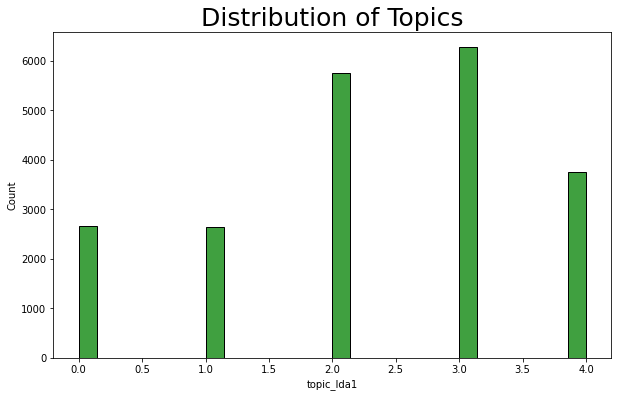

In [ ]:
plt.figure(figsize=[10,6])
sns.histplot(data=re, x='topic_lda1',color='Green', )
plt.title("Distribution of Topics", fontsize=25)
plt.show()

In [ ]:

df_clean12=df_clean

In [ ]:
extracted_col = re["topic_lda1"]

df_clean12.insert(1, "C4", extracted_col)


In [ ]:
df_clean12.head(1)

complaint_what_happened  \
1  Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.   

    C4  \
1  3.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                             processed_complaint  \
1  good morning my name is   and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account     thanks in advance for your help   

                                                                                                                                                                                                                                                        lemmatized_complaint  \
1  [[good, morning, appreciate, help, stop, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, month, attempt, collect, debt, right, know, information, consumer, chase, account, thank, advance, help]]   

                                                                                                      complaint_POS_removed  \
1  morning stop debt verification statement bank debt mail month debt right information consumer chase account advance help   

   len  \
1  126   

                                                                                                                                                                                                                                                                                                      1_gram  \
1  [good, morning, appreciate, help, stop, chase, bank, cardmember, service, write, chase, ask, debt, verification, send, statement, acceptable, ask, bank, validate, debt, instead, receive, mail, month, attempt, collect, debt, right, know, information, consumer, chase, account, thank, advance, help]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              bi_gram  \
1  [good morning, morning appreciate, appreciate help, help stop, stop chase, chase bank, bank cardmember, cardmember service, service write, write chase, chase ask, ask debt, debt verification, verification send, send statement, statement acceptable, acceptable ask, ask bank, bank validate, validate debt, debt instead, instead receive, receive mail, mail month, month attempt, attempt collect, collect debt, debt right, right know, know information, information consumer, consumer chase, chase account, account thank, thank advance, advance help]   

            

In [ ]:
#df_clean12=df_clean12.assign(topiclda=re['topic_lda'])

In [ ]:
df_clean12['lemmatized_complaint']=df_clean12['lemmatized_complaint'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw_spacy]))

In [ ]:
def reqpos(df_clean12):
    texts=df_clean12['lemmatized_complaint']
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    texts_out = []
    texts_out.append([token for token in spacy_nlp_en(texts)  if token.pos_ in allowed_postags])
    
    return texts_out
    

In [ ]:
df_clean12['lemmatized_complaint']=df_clean12.swifter.apply(reqpos,axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [ ]:
#allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

In [ ]:
df_clean12['lemmatized_complaint1']=df_clean12['lemmatized_complaint'].apply(lambda x:x[0])

In [ ]:
df_clean12['lemmatized_complaint1']=df_clean12['lemmatized_complaint1'].apply(lambda x:' '.join([str(elem) for elem in x]))

list

In [ ]:
re.shape

(21072, 6)

In [ ]:
df_clean12['C4'].isnull().sum()

13947

In [ ]:
from sklearn.model_selection  import train_test_split
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(df_clean12['complaint_POS_removed'], re.topic_lda1, random_state=11,test_size=0.25)

numpy.float64

In [ ]:
tfidfconverter = TfidfVectorizer(max_df = 0.95,min_df = 2)
x_train_tfidf = tfidfconverter.fit_transform(list(X_train_lda)).toarray()
x_train_tfidf_all = pd.DataFrame(x_train_tfidf,columns=tfidfconverter.get_feature_names())

In [ ]:
x_train_tfidf_all.head()

aarp   ab  aba  abbreviation  abet  abide  ability  abovereference  \
0   0.0  0.0  0.0           0.0   0.0    0.0      0.0             0.0   
1   0.0  0.0  0.0           0.0   0.0    0.0      0.0             0.0   
2   0.0  0.0  0.0           0.0   0.0    0.0      0.0             0.0   
3   0.0  0.0  0.0           0.0   0.0    0.0      0.0             0.0   
4   0.0  0.0  0.0           0.0   0.0    0.0      0.0             0.0   

   absence  absent  absolve  absurdity  abundance  abuse  abuser   ac  \
0      0.0     0.0      0.0        0.0        0.0    0.0     0.0  0.0   
1      0.0     0.0      0.0        0.0        0.0    0.0     0.0  0.0   
2      0.0     0.0      0.0        0.0        0.0    0.0     0.0  0.0   
3      0.0     0.0      0.0        0.0        0.0    0.0     0.0  0.0   
4      0.0     0.0      0.0        0.0        0.0    0.0     0.0  0.0   

   acccount  acceleration  accent  accept  acceptance  access  accessory  \
0       0.0           0.0     0.0     0.0         0.0     0.0        0.0   
1       0.0           0.0     0.0     0.0         0.0     0.0        0.0   
2       0.0           0.0     0.0     0.0         0.0     0.0        0.0   
3       0.0           0.0     0.0     0.0         0.0     0.0        0.0   
4       0.0           0.0     0.0     0.0         0.0     0.0        0.0   

   accident  accommodation  accomodation  accompany  accomplice  accont  \
0       0.0            0.0           0.0        0.0         0.0     0.0   
1       0.0            0.0           0.0        0.0         0.0     0.0   
2       0.0            0.0           0.0        0.0         0.0     0.0   
3       0.0            0.0           0.0        0.0         0.0     0.0   
4       0.0            0.0           0.0        0.0         0.0     0.0   

   accord  accordance  accou  accouint  accoun  accound   account  \
0     0.0    0.000000    0.0       0.0     0.0      0.0  0.084474   
1     0.0    0.000000    0.0       0.0     0.0      0.0  0.148763   
2     0.0    0.055992    0.0       0.0     0.0      0.0  0.083667   
3     0.0    0.000000    0.0       0.0     0.0      0.0  0.380855   
4     0.0    0.000000    0.0       0.0     0.0      0.0  0.230566   

   accountability  accountalso  accountand  accountant  accountchase  \
0             0.0          0.0         0.0         0.0           0.0   
1             0.0          0.0         0.0         0.0           0.0   
2             0.0          0.0         0.0         0.0           0.0   
3             0.0          0.0         0.0         0.0           0.0   
4             0.0          0.0         0.0         0.0           0.0   

   accountholder  accounti  accounting  accountit  accountlevel  \
0            0.0       0.0         0.0        0.0           0.0   
1            0.0       0.0         0.0        0.0           0.0   
2            0.0       0.0         0.0        0.0           0.0   
3            0.0       0.0         0.0        0.0           0.0   
4            0.0       0.0         0.0        0.0           0.0   

   accountplease  accountshe  accountsince  accout  accredit  accrue  acct  \
0            0.0         0.0           0.0     0.0       0.0     0.0   0.0   
1            0.0         0.0           0.0     0.0       0.0     0.0   0.0   
2            0.0         0.0           0.0     0.0       0.0     0.0   0.0   
3            0.0         0.0           0.0     0.0       0.0     0.0   0.0   
4            0.0         0.0           0.0     0.0       0.0     0.0   0.0   

   accumulate  accumulation  accuracy  accurateness  accusation  accuse  ach  \
0         0.0           0.0       0.0           0.0         0.0     0.0  0.0   
1         0.0           0.0       0.0           0.0         0.0     0.0  0.0   
2         0.0           0.0       0.0           0.0         0.0     0.0  0.0   
3         0.0           0.0       0.0           0.0         0.0     0.0  0.0   
4         0.0           0.0       0.0           0.0         0.0     0.0  0.0   

   acivity  ackn

In [ ]:
x_train_tfidf_all.shape

(15804, 6046)

In [ ]:
x_test_tfidf = tfidfconverter.transform(list(X_test_lda)).toarray()
x_test_tfidf_all = pd.DataFrame(x_test_tfidf,columns=tfidfconverter.get_feature_names())

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial')
model1=lr.fit(x_train_tfidf_all, y_train_lda)